In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!/usr/bin/env python3
import tqdm
from typing import List, Dict, Tuple, Hashable, Union
from dataclasses import dataclass
from simple_parsing import Serializable
import logging

import torch as th
from torchvision.transforms import Compose
from torch.utils.data._utils.collate import default_collate
from pytorch3d.transforms import quaternion_to_matrix

from top.data.transforms import (
    Normalize,
    InstancePadding,
    DenseMapsMobilePose
)
from top.data.transforms.keypoint import (
    BoxPoints2D
)
from top.data.transforms.bounding_box import (
    SolveTranslation
)
from top.data.bbox_reg_util import CropObject
from top.data.load import (DatasetSettings, collate_cropped_img, get_loaders)
from top.data.schema import Schema
from top.train.trainer import Saver
from top.run.path_util import RunPath, get_latest_file
from top.run.app_util import update_settings
from top.run.torch_util import resolve_device

from top.model.bbox_3d import BoundingBoxRegressionModel
from top.run.draw_regressed_bbox import plot_regressed_3d_bbox, plot_3d_box

from matplotlib import pyplot as plt

In [3]:
@dataclass
class TempSettings(Serializable):
    model:BoundingBoxRegressionModel.Settings = BoundingBoxRegressionModel.Settings()
        
def load_model():
    device = resolve_device('cuda')
#     from bb_regression import AppSettings

    # Configure checkpoints + options
    ckpt = '/media/ssd/models/top/ckpt/step-117999.zip'
    opts = TempSettings()

    opts.load('/media/ssd/models/top/opts.yaml')
    opts = opts.model
    # 1. load bbox regression model
    model = BoundingBoxRegressionModel(opts).to(device)
    logging.info(F'Loading checkpoint {ckpt} ...')
    Saver(model).load(ckpt)

    return model

In [4]:
# data
transform = Compose([CropObject(CropObject.Settings()), Normalize(
    Normalize.Settings(keys=(Schema.CROPPED_IMAGE,)))])
_, test_loader = get_loaders(DatasetSettings(),
                             th.device('cpu'),
                             1,
                             transform=transform,
                             collate_fn=collate_cropped_img)
# model
device = th.device('cuda')
model = load_model()
model = model.to(device)
model.eval()

Dropping extra args {'alpha': 0.5, 'batch_size': 64, 'dataset': {'cache': {'cache_dir': '~/.cache/ai604/', 'force_rebuild': False, 'num_samples': 8}, 'cube': {'aspect': 1.0, 'batch_size': 1, 'fov': 60, 'image_size': [256, 256], 'max_distance': 10.0, 'min_distance': 0.1, 'unstack': True, 'use_mesh': False, 'zfar': 100.0, 'znear': 0.1}, 'dataset': 'OBJECTRON', 'num_workers': 0, 'objectron': {'bucket_name': 'objectron', 'cache_dir': '~/.cache/ai604/', 'classes': ['bike', 'book', 'bottle', 'camera', 'cereal_box', 'chair', 'cup', 'laptop', 'shoe'], 'context': ['count', 'sequence_id'], 'features': ['instance_num', 'image/width', 'image/height', 'image/channels', 'image/encoded', 'object/name', 'object/translation', 'object/orientation', 'object/scale', 'object/visibility', 'point_3d', 'point_2d', 'point_num', 'camera/intrinsics', 'camera/projection'], 'local': True, 'shuffle_shards': True}, 'shuffle': False, 'use_cached_dataset': False}, 'device': 'cuda', 'eval_period': 1000, 'load_ckpt': ''

BoundingBoxRegressionModel(
  (features): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
      

In [5]:
idata = iter(test_loader)

In [6]:
data = next(idata)

/home/jamiecho/Repos/Ravel/ai604-video-object-pose/src/top/data/objectron_detection.py:55: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  image = thio.decode_image(th.from_numpy(image_bytes))


In [70]:
fetched = []
for count in range(4):    
    data = next(idata)
    fetched.append(data)

In [73]:
# translation solver
solve_translation = SolveTranslation()
output_images = []
output_images2 = []
output_images3 = []
for count in range(4):    
#     data = next(idata)
    data = fetched[count]
    with th.no_grad():
        # run inference
        crop_img = data[Schema.CROPPED_IMAGE].view(-1, 3, 224, 224)
        dim, quat = model(crop_img.to(device))
        dim2, quat2 = data[Schema.SCALE], data[Schema.QUATERNION]
        print('D {} {}'.format(dim, dim2))
        print('Q {} {}'.format(quat, quat2))
        trans2 = data[Schema.TRANSLATION]

        if False:
            dim = dim2
            quat = quat2
            R = quaternion_to_matrix(quat)

        R = quaternion_to_matrix(quat)

        input_image = data[Schema.IMAGE].detach().cpu()
        proj_matrix = (
            data[Schema.PROJECTION].detach().cpu().reshape(-1, 4, 4))

        translations = []
        for i in range(len(proj_matrix)):

            box_i, box_j, box_h, box_w = data[Schema.BOX_2D][i]
            box_2d = th.as_tensor(
                [box_i, box_j, box_i + box_h, box_j + box_w])
            box_2d = 2.0 * (box_2d - 0.5)
            
            args = {
                # inputs from dataset
                Schema.PROJECTION: proj_matrix[i],
                Schema.BOX_2D: box_2d,
                # inputs from network
                Schema.ORIENTATION: R[i],
                Schema.QUATERNION: quat[i],
                Schema.SCALE: dim[i],
                Schema.TRANSLATION : data[Schema.TRANSLATION][i]
            }

            # Solve translation
            translation, _ = solve_translation(args)
            translations.append(translation)

        translations = th.as_tensor(translations, dtype=th.float32)
        print('T {} {}'.format(translations, trans2))
        dimensions = dim.detach().cpu()
        quaternion = quat.detach().cpu()
        R = quaternion_to_matrix(quaternion[None])[0].detach().cpu().numpy()
        translations = translations.detach().cpu()

        #print(input_image.shape)
        #print(data[Schema.BOX_2D].shape)
        #print(proj_matrix.shape)
        #print(translations.shape)
        #print(dimensions.shape)
        #print(quaternion.shape)

        # draw box
#         print(input_image.shape)
        print(R.shape)
        print(dimensions.shape)
        print(translations.shape)
        # NOTE(ycho): plot_3d_bbox uses the supplied translations,
        # which were computed as the least-error solution based on forward evaluation
        image_with_box = plot_3d_box(
            input_image[0],
            proj_matrix[0],
            R[0],
            dimensions[0],
            translations[0])
        
        # NOTE(ycho): plot_regressed_3d_bbox uses ground-truth correspondences,
        # to solve the translations internally (argument is ignored)
        iwb2 = plot_regressed_3d_bbox(
            input_image,
            data[Schema.KEYPOINT_2D],
            proj_matrix,
            dimensions,
            quaternion,
            translations)
        
        # NOTE(ycho): Ground-truth
        iwb3 = plot_3d_box(
            input_image[0],
            proj_matrix[0],
            quaternion_to_matrix(quat2[None])[0].detach().cpu().numpy(),
            data[Schema.SCALE][0].detach().cpu().numpy(),
            data[Schema.TRANSLATION][0].detach().cpu().numpy())


#         plt.imshow(image_with_box.permute(1, 2, 0))
        output_images.append(image_with_box.transpose(1, 2, 0))
        output_images2.append(iwb2.permute(1, 2, 0))
        output_images3.append(iwb3.transpose(1, 2, 0))

D tensor([[0.5861, 0.9471, 0.5526]], device='cuda:0') tensor([[0.6400, 0.9800, 0.6100]])
Q tensor([[ 0.6620,  0.2947, -0.1701,  0.3607]], device='cuda:0') tensor([[0.6678, 0.0838, 0.3226, 0.6655]])
T tensor([[ 0.1476, -0.0788, -1.3742]]) tensor([[ 0.1271, -0.1053, -1.2952]])
(1, 3, 3)
torch.Size([1, 3])
torch.Size([1, 3])
lstsq error: [0.00193586]
D tensor([[0.6120, 0.9307, 0.6367]], device='cuda:0') tensor([[0.5200, 0.8500, 0.5700]])
Q tensor([[ 0.6765,  0.6452, -0.2909,  0.3359]], device='cuda:0') tensor([[ 0.5725,  0.6934, -0.3551,  0.2558]])
T tensor([[ 0.1243, -0.1771, -1.4539]]) tensor([[ 0.1000, -0.1194, -1.2524]])
(1, 3, 3)
torch.Size([1, 3])
torch.Size([1, 3])
lstsq error: [0.00119362]
D tensor([[0.6437, 0.9443, 0.6444]], device='cuda:0') tensor([[0.6800, 0.8000, 0.6800]])
Q tensor([[ 0.7044,  0.5176, -0.1971,  0.5479]], device='cuda:0') tensor([[ 0.6369,  0.6015, -0.3139,  0.3660]])
T tensor([[-3.0567e-01, -8.5143e-04, -1.5409e+00]]) tensor([[-0.2684, -0.0081, -1.4471]])
(1, 

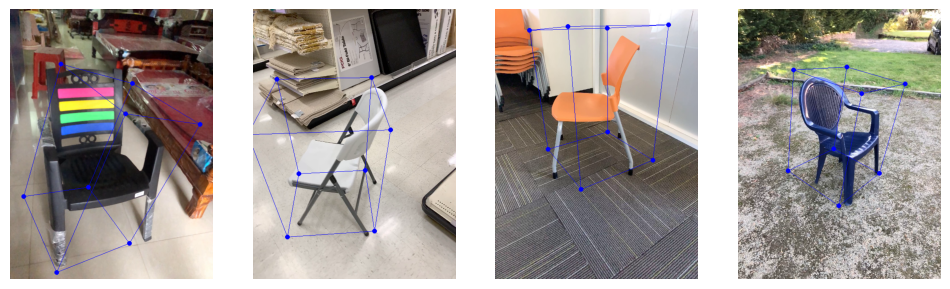

In [74]:
# plt.figure()
fig,ax=plt.subplots(1,4, figsize=(12,8), dpi= 100)
for i in range(4):
    ax[i].imshow(output_images[i])
    ax[i].set_axis_off()
plt.savefig('/tmp/result.png', bbox_inches='tight')
# plt.axis('off')

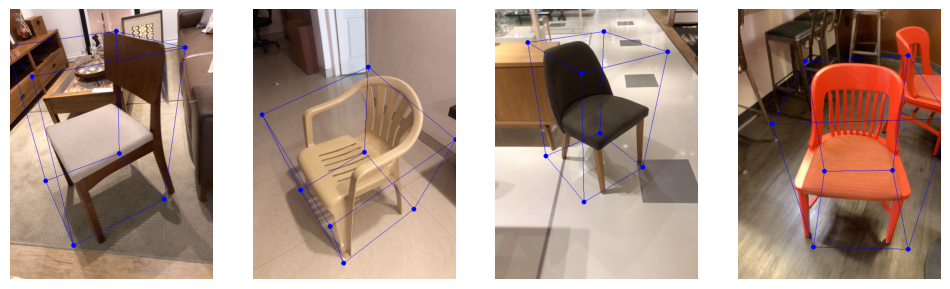

In [51]:
# plt.figure()
fig,ax=plt.subplots(1,4, figsize=(12,8), dpi= 100)
for i in range(4):
    ax[i].imshow(output_images2[i])
    ax[i].set_axis_off()
# plt.savefig('/tmp/result.png', bbox_inches='tight')
# plt.axis('off')

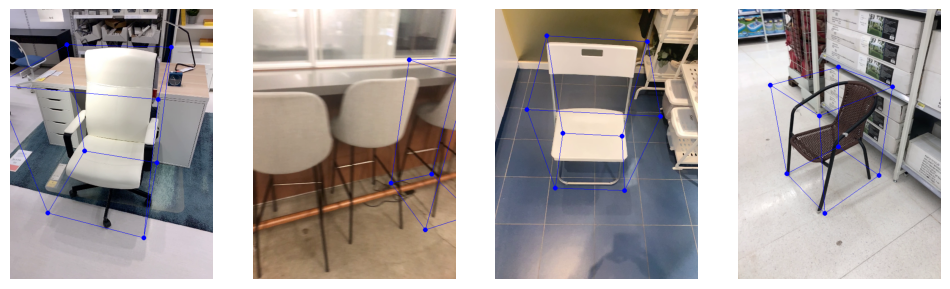

In [42]:
# plt.figure()
fig,ax=plt.subplots(1,4, figsize=(12,8), dpi= 100)
for i in range(4):
    ax[i].imshow(output_images3[i])
    ax[i].set_axis_off()
# plt.savefig('/tmp/result.png', bbox_inches='tight')
# plt.axis('off')